In [11]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.Resize((128, 128)),                  # Resize to smaller image size for faster processing
    transforms.RandomHorizontalFlip(p=0.5),         # Basic augmentation
    transforms.RandomRotation(degrees=15),          # Light rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Optional: add slight color variance
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])


In [ ]:
transform_test = transforms.Compose([
    transforms.Resize((128, 128)),                  # Same size as training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [13]:
# Root path where "train", "valid", "test" folders exist
data_dir = 'E:/final project/Dataset/New Plant Diseases Dataset'

# Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform_train)
valid_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'valid'), transform=transform_test)
test_dataset  = datasets.ImageFolder(root=os.path.join(data_dir, 'test'),  transform=transform_test)

# Check class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")


Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___

In [14]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [ ]:
num_classes = len(train_dataset.classes)
model = AdvancedPlantDiseaseCNN(num_classes=num_classes).to(device)

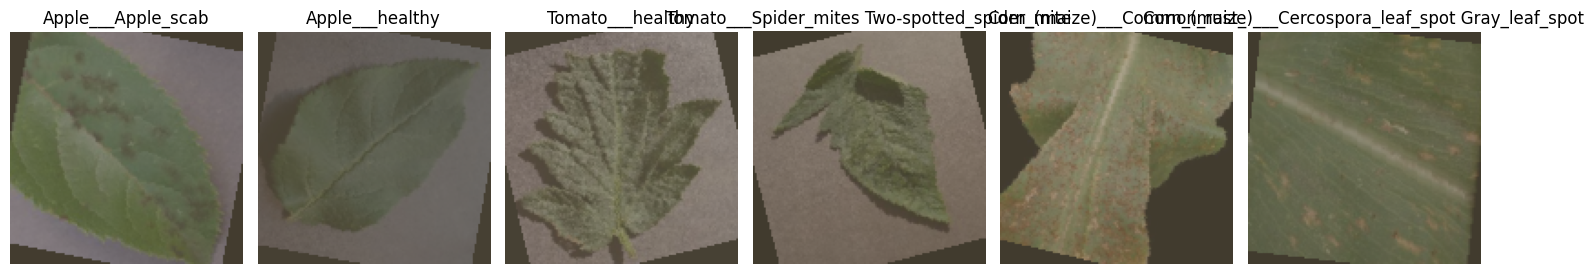

In [15]:
import numpy as np

def show_batch(data_loader):
    images, labels = next(iter(data_loader))
    fig, axes = plt.subplots(1, 6, figsize=(15, 5))
    for i in range(6):
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = img.clip(0, 1)
        axes[i].imshow(img)
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_batch(train_loader)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class AdvancedPlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(AdvancedPlantDiseaseCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 256 → 128

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 128 → 64

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 64 → 32
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),          
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AdvancedPlantDiseaseCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5, verbose=True)


In [ ]:
best_val_acc = 0
patience = 5
counter = 0

for epoch in range(10):  
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = 100 * train_correct / train_total

    # Validation
    model.eval()
    val_correct, val_total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_custom_cnn.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


In [ ]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load("best_custom_cnn.pth"))
model.eval()

correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"Test Accuracy of Advanced CNN: {test_acc:.2f}%")
